# <center> Explonatory Data Analysis

**Data fields**
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

Read files from ETL notebooks

In [1]:
%store -r item_cat
%store -r item
%store -r sub
%store -r shops
%store -r sales_test
%store -r sales_train

Library import

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# Initialize plotly
init_notebook_mode(connected=True)

from IPython.core.debugger import set_trace
from time import time

from tqdm import tqdm
tqdm.pandas(desc="")
warnings.filterwarnings("ignore")
import os

## Sklearn
from sklearn.cluster import KMeans

Helper methods

In [3]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

def get_default_layout(title="", xlab="", ylab=""):
    layout = go.Layout(
        title=go.layout.Title(
            text=title,
            xref='paper',
        ),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(
                text=xlab
            )
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=ylab
            )
        )
    )
    return layout

def show_plotly(data, title="", xlab="", ylab=""):
    plotly.offline.iplot(go.Figure(data=data, layout=get_default_layout(title,xlab,ylab)))

## Data leak analysis

### Train dataset

Sales_train has no null valeus

In [4]:
sales_train.replace([np.inf, np.NINF], np.nan).isnull().apply(lambda x: x.value_counts())

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
False  2935849         2935849  2935849  2935849     2935849       2935849

In [5]:
sales_train.isnull().apply(lambda x: x.value_counts())

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
False  2935849         2935849  2935849  2935849     2935849       2935849

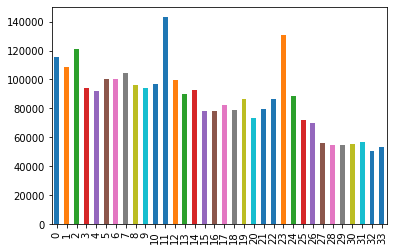

In [6]:
v = sales_train['date_block_num'].value_counts()
v[v.index.sort_values()].plot(kind='bar')

Duplicated items:

In [11]:
unique_items = sales_train.drop_duplicates(['date', 'item_id', 'shop_id'])
sales_train.shape[0] - unique_items.shape[0]

Some items duplicate each other. I will print items which items duplicate each other

In [36]:
#%%time
duplicated_cols = sales_train.groupby(['date', 'item_id', 'shop_id'])['date_block_num'].count().reset_index()
duplicated_cols = duplicated_cols[duplicated_cols['date_block_num'] > 1].rename(columns={'date_block_num': 'count'})
duplicated_cols['count'].value_counts()

In [42]:
duplicated_cols[['item_id', 'shop_id']]

item_id  shop_id
79678      14050       31
89472      15702       38
94677      12133       25
116495     12133       16
161438     12133       25
170916     15702       16
428704     20130       54
532081     14050       54
628822     12133       50
1237652    12133       54
1246997    12133       27
1281069     3423       50
1427169     3423       50
1505817     3423       21
1528466    16875       31
1899962     9842       31
1906967    16587       56
1960975    12133       31
2162594    16587       31
2208732     3423       25
2264452     8237       31
2279370     3424       17
2319130     8237       57
2323229    21619       42
2422361    21619        5
2434002    16587       25
2705725    21619       12
2921182    21619       42

### Test dataset

In [7]:
sales_train[['date_block_num', 'item_price', 'item_cnt_day']].describe()

date_block_num    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  8.908532e+02  1.242641e+00
std      9.422988e+00  1.729800e+03  2.618834e+00
min      0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.990000e+02  1.000000e+00
75%      2.300000e+01  9.990000e+02  1.000000e+00
max      3.300000e+01  3.079800e+05  2.169000e+03

Duplicated items:

In [44]:
unique_items = sales_test.drop_duplicates(['item_id', 'shop_id'])
sales_test.shape[0] - unique_items.shape[0]

0

## Initial Data Analysis

In [9]:
df = sales_train[['item_price','item_cnt_day']]

pd.concat([df.describe().T,
                      df.median().rename('median'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt')
                     ], axis=1).T

item_price  item_cnt_day
count   2.935849e+06  2.935849e+06
mean    8.908532e+02  1.242641e+00
std     1.729800e+03  2.618834e+00
min    -1.000000e+00 -2.200000e+01
25%     2.490000e+02  1.000000e+00
50%     3.990000e+02  1.000000e+00
75%     9.990000e+02  1.000000e+00
max     3.079800e+05  2.169000e+03
median  3.990000e+02  1.000000e+00
skew    1.075042e+01  2.728332e+02
kurt    4.455328e+02  1.774781e+05

Time length

In [10]:
sales_train['date_block_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

Categories count

In [11]:
item['item_category_id'].nunique()

84

Item per Categories

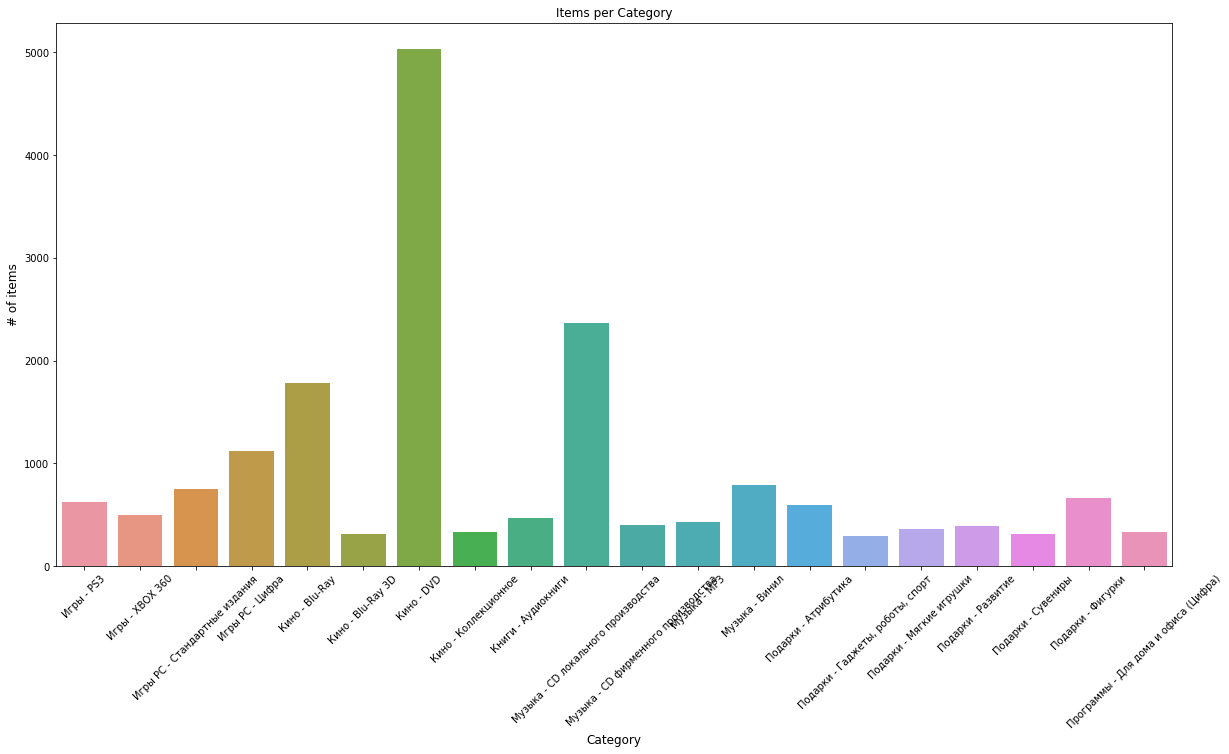

In [12]:
item_cat_grouped = item.groupby('item_category_id').count().sort_values('item_id', ascending=False).iloc[:20]
item_cat_grouped = item_cat.set_index('item_category_id').join(item_cat_grouped, on='item_category_id', how='inner')
plt.figure(figsize=(20, 10))
ax = sns.barplot(item_cat_grouped.item_category_name, item_cat_grouped.item_id)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [13]:
item_cat_grouped.reset_index().drop(['item_category_name', 'item_name'], axis=1).describe()

item_category_id      item_id
count         20.000000    20.000000
mean          49.900000   894.300000
std           16.876954  1109.312357
min           19.000000   295.000000
25%           37.750000   357.750000
50%           55.500000   486.000000
75%           62.250000   764.500000
max           76.000000  5035.000000

Item per category distribution

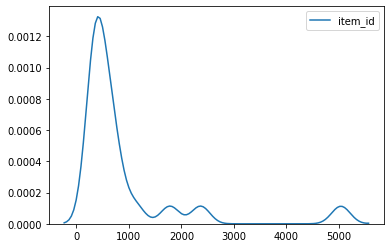

In [14]:
sns.kdeplot(item_cat_grouped['item_id'])

In [15]:
item_id = item_cat_grouped['item_id']
item_id[item_id > 4000]

item_category_id
40    5035
Name: item_id, dtype: int64

In [16]:
item_id[item_id > 500]

item_category_id
19     628
23     501
30     756
31    1125
37    1780
40    5035
55    2365
58     790
61     598
72     666
Name: item_id, dtype: int64

Category item count

In [17]:
print(f"Item count: {sales_train['item_id'].nunique()}")
print(f"Shop count: {sales_train['shop_id'].nunique()}")

Item count: 21807
Shop count: 60


Items per shop

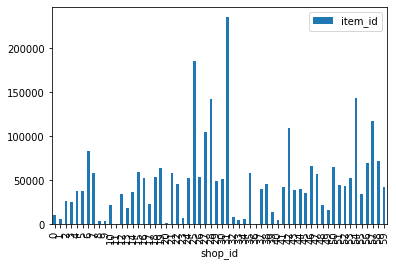

In [18]:
sales_train[['item_id', 'shop_id']].groupby('shop_id').count().plot(kind='bar')

## Monthly sales 

In [19]:
sales_train = sales_train.set_index('date')
KEY = ['shop_id', 'item_id']
ms = sales_train.reset_index().drop(['date', 'item_price'], axis=1).groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False).sum()

ms.to_pickle('../data/ms.pickle')

In [20]:
key_item_price = sales_train[['shop_id', 'item_id', 'item_price']].groupby(['shop_id', 'item_id'], as_index=False).mean()
ms = ms.merge(key_item_price, how='left', on=['shop_id', 'item_id'], right_index=False)

In [21]:
def item_cnt_grouped(df, column, title, cnt=10):    
    grouped_by_shop_date = df[[column, 'date_block_num', 'item_cnt_day']].groupby([column, 'date_block_num'], as_index=False).sum()
    max_samples = grouped_by_shop_date.groupby(column, as_index=False).sum().sort_values(by=['item_cnt_day'], ascending=False).head(cnt)[column]
    grouped_by_shop_date_sorted  = grouped_by_shop_date[np.isin(grouped_by_shop_date[column], max_samples)].sort_values(by=[column, 'date_block_num'])

    def date_cnt_plot(key):
        df = grouped_by_shop_date_sorted[grouped_by_shop_date[column] == key] 
        return go.Scatter(x=df['date_block_num'], y=df['item_cnt_day'], name= title + " " + str(key))
    
    data = [date_cnt_plot(i) for i in grouped_by_shop_date[column].unique()]
    layout = dict(title="Month sales for all stores")
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

Month sales by all items

In [22]:
grouped_by_date = ms[['date_block_num', 'item_cnt_day']].groupby(['date_block_num'], as_index=False).sum().sort_values(by=['date_block_num'])

data = [go.Scatter(y=grouped_by_date['item_cnt_day'], x=grouped_by_date['date_block_num'])]
layout = dict(title="Month sales for all stores")
fig = dict(data=data, layout=layout)
iplot(fig, show_link=False)

Monthly sales avg by item

In [23]:
item_cnt_grouped(ms, 'item_id', title = 'Item: ')

Monthly sales avg by shop

In [24]:
item_cnt_grouped(ms, 'shop_id', title = 'Shop:')

Difference between months

In [25]:
grouped_by_date.head()

date_block_num  item_cnt_day
0               0      131479.0
1               1      128090.0
2               2      147142.0
3               3      107190.0
4               4      106970.0

In [26]:
months_shifts = [1, 2, 4, 6, 12]
fig = make_subplots(rows=len(months_shifts), cols=1, subplot_titles=list(map(lambda month: "Shift: " + str(month), months_shifts)))
for i, month in enumerate(months_shifts):
    shift = grouped_by_date - grouped_by_date.shift(month).fillna(0)
    fig.add_trace(
        go.Scatter(
            x=shift.index, 
            y=shift['item_cnt_day'], 
            showlegend=False), 
        row=i+1, 
        col=1)


fig.update_layout(height=1200, title_text="Difference between months") 
fig.show()

Returned products:

In [27]:
returned_items = sales_train[sales_train['item_cnt_day'] < 0].groupby('date_block_num')\
.sum().reset_index().rename(columns={'item_cnt_day': 'returned_items'})

returned_items['returned_items'] = returned_items['returned_items'] * -1

fig = px.line(returned_items, x="date_block_num", y="returned_items", line_shape="spline")
fig.show()

Item duration life

In [28]:
pd.options.display.float_format = '{:,.2f}'.format

In [29]:
ms.groupby(['item_id', 'shop_id'])['date_block_num'].count().describe()

count   424,124.00
mean          3.79
std           4.15
min           1.00
25%           1.00
50%           2.00
75%           5.00
max          34.00
Name: date_block_num, dtype: float64

Most popular months

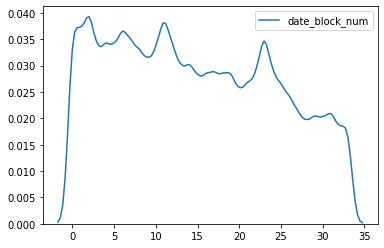

In [30]:
sns.kdeplot(ms['date_block_num'])

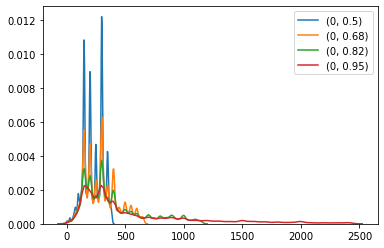

In [31]:
item_price = ms['item_price']

rang = [0.5, 0.68, 0.82, 0.95]

fig = plt.figure()
for i in rang:    
    q = np.quantile(item_price, (0, i))
    ax = sns.kdeplot(item_price[(item_price > q[0]) & (item_price < q[1])])
    fig.add_subplot(ax)
    ax.legend(list(zip(np.repeat(0, len(rang)), rang)))

In [32]:
kmeans = KMeans(6)
kmeans.fit(ms['item_price'].values.reshape(-1, 1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [33]:
pd.Series(kmeans.predict(ms['item_price'].values.reshape(-1, 1))).value_counts()

0    1179778
3     324076
2      91910
1      10527
4       2832
5          1
dtype: int64

In [35]:
kmeans = KMeans(8)
kmeans.fit(ms['item_price'].values.reshape(-1, 1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
pd.Series(kmeans.predict(ms['item_price'].values.reshape(-1, 1))).value_counts()

1    1078506
7     311260
4     162987
0      42267
5       6442
2       5154
3       2507
6          1
dtype: int64

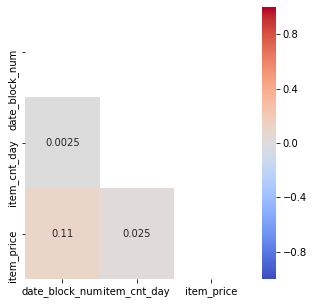

In [34]:
corr = ms.drop(['item_id', 'shop_id'], axis=1).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            mask = mask);

In [ ]:
ms[']